# Import Packages

In [23]:
# Numerical Operations
import numpy as np
import math
from matplotlib import pyplot as plt

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Useful Functions

In [24]:
def same_seed(seed): 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def predict(test_loader, model, device):
    model.eval()
    preds_list = list()
    labels_list = list()
    for imgs, labels in tqdm(test_loader):
        imgs = imgs.to(device)
        labels_list += labels.squeeze().tolist()                       
        with torch.no_grad():  
            pred = model(imgs) 
            pred_label = np.argmax(pred.cpu().data.numpy(), axis=1)
            preds_list += pred_label.squeeze().tolist()          
    return preds_list, labels_list


def save_pred(preds, file):
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'pred'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])


def cal_l2(model):
    l2_weight = 0.1
    l2_parameters = list()
    for parameter in model.parameters():
        l2_parameters.append(parameter.view(-1))
        l2 = l2_weight * model.compute_l2_loss(torch.cat(l2_parameters))
    return l2

# Datasets

In [25]:
MNIST_train = datasets.MNIST('./training', train=True, download=False, transform=transforms.ToTensor())
MNIST_test = datasets.MNIST('./testing', train=False, download=False, transform=transforms.ToTensor())
train_set, valid_set = torch.utils.data.random_split(MNIST_train, [55000, 5000])
test_set = MNIST_test

# Configurations

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    'seed':6666,
    'n_epochs': 100,     # Number of epochs.            
    'batch_size': 64, 
    'learning_rate': 1e-4,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# DataLoder

In [27]:
train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

# Module

In [29]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input dim [1, 28, 28]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),  # [64, 28, 28]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 14, 14]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 14, 14]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 7, 7]

            nn.Conv2d(128, 512, 3, 1, 1), # [512, 7, 7]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [512, 3, 3]

        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512*3*3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10) # 0~9
        )


    def forward(self, x):
        out = self.cnn_layers(x)
        out = out.view(out.size()[0], -1)
        return self.fc_layers(out)


    def compute_l2_loss(self, w):
        return torch.square(w).sum()

# Training Loop

In [1]:
def trainer(train_loader, valid_loader, test_loader, model, config, device):

    criterion = nn.CrossEntropyLoss() 
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])


    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set model to train mode.
        train_loss = []
        train_accs = []

        train_pbar = tqdm(train_loader, position=0, leave=True)

        for imgs, labels in train_pbar:
            
            imgs, labels = imgs.to(device), labels.to(device)   # Move your data to device. 
            pred = model(imgs)  

            loss = criterion(pred, labels)
            l2 = cal_l2(model)
            loss += l2

            acc = (pred.argmax(dim=-1) == labels.to(device)).float().mean()
            optimizer.zero_grad()               # Set gradient to zero.
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            
            train_loss.append(loss.detach().item())
            train_accs.append(acc)
            
            step += 1
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(train_loss) / len(train_loss)
        mean_train_acc = sum(train_accs) / len(train_accs)


        model.eval() # Set your model to evaluation mode.
        valid_loss = []
        valid_accs = []
        test_loss = []
        test_accs = []

        for imgs, labels in valid_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                pred = model(imgs)
                loss = criterion(pred, labels)
                l2 = cal_l2(model)
                loss += l2
                acc = (pred.argmax(dim=-1) == labels.to(device)).float().mean()

            valid_loss.append(loss.item())
            valid_accs.append(acc)
            
        mean_valid_loss = sum(valid_loss) / len(valid_loss)
        mean_valid_acc = sum(valid_accs) / len(valid_accs)
        
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')


        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                pred = model(imgs)
                loss = criterion(pred, labels)
                l2 = cal_l2(model)
                loss += l2
                acc = (pred.argmax(dim=-1) == labels.to(device)).float().mean()

            test_loss.append(loss.item())
            test_accs.append(acc)

        mean_test_loss = sum(test_loss) / len(test_loss)
        mean_test_acc = sum(test_accs) / len(test_accs)


        writer.add_scalars('Loss', {'train':mean_train_loss, 'valid':mean_valid_loss, 'test':mean_test_loss}, step)
        writer.add_scalars('Accuracy', {'train':mean_train_acc, 'valid':mean_valid_acc, 'test':mean_test_acc}, step)


        for name, parms in model.named_parameters():
            writer.add_histogram(name, parms, step)


        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1


        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return
        


# Start training

In [31]:
# Set seed for reproducibility
same_seed(config['seed'])

model = Classifier().to(device)
trainer(train_loader, valid_loader, test_loader, model, config, device)

Epoch [1/100]: 100%|██████████| 860/860 [00:08<00:00, 104.67it/s, loss=60.9]


Epoch [1/100]: Train loss: 71.4542, Valid loss: 60.9858
Saving model with loss 60.986...


Epoch [2/100]: 100%|██████████| 860/860 [00:07<00:00, 108.91it/s, loss=50.2]


Epoch [2/100]: Train loss: 55.3764, Valid loss: 50.1745
Saving model with loss 50.174...


Epoch [3/100]: 100%|██████████| 860/860 [00:07<00:00, 115.96it/s, loss=41]  


Epoch [3/100]: Train loss: 45.4702, Valid loss: 41.0225
Saving model with loss 41.023...


Epoch [4/100]: 100%|██████████| 860/860 [00:07<00:00, 114.27it/s, loss=33.1]


Epoch [4/100]: Train loss: 36.9786, Valid loss: 33.1247
Saving model with loss 33.125...


Epoch [5/100]: 100%|██████████| 860/860 [00:07<00:00, 119.40it/s, loss=26.3]


Epoch [5/100]: Train loss: 29.6287, Valid loss: 26.3043
Saving model with loss 26.304...


Epoch [6/100]: 100%|██████████| 860/860 [00:07<00:00, 121.39it/s, loss=20.4]


Epoch [6/100]: Train loss: 23.2827, Valid loss: 20.4514
Saving model with loss 20.451...


Epoch [7/100]: 100%|██████████| 860/860 [00:06<00:00, 123.09it/s, loss=15.5]


Epoch [7/100]: Train loss: 17.8655, Valid loss: 15.4622
Saving model with loss 15.462...


Epoch [8/100]: 100%|██████████| 860/860 [00:06<00:00, 123.46it/s, loss=11.3]


Epoch [8/100]: Train loss: 13.3341, Valid loss: 11.3927
Saving model with loss 11.393...


Epoch [9/100]: 100%|██████████| 860/860 [00:06<00:00, 124.23it/s, loss=8.03]


Epoch [9/100]: Train loss: 9.6534, Valid loss: 8.1374
Saving model with loss 8.137...


Epoch [10/100]: 100%|██████████| 860/860 [00:06<00:00, 124.59it/s, loss=5.56]


Epoch [10/100]: Train loss: 6.7949, Valid loss: 5.6713
Saving model with loss 5.671...


Epoch [11/100]: 100%|██████████| 860/860 [00:06<00:00, 123.52it/s, loss=3.93]


Epoch [11/100]: Train loss: 4.7192, Valid loss: 3.9914
Saving model with loss 3.991...


Epoch [12/100]: 100%|██████████| 860/860 [00:06<00:00, 124.43it/s, loss=2.91]


Epoch [12/100]: Train loss: 3.3796, Valid loss: 2.9512
Saving model with loss 2.951...


Epoch [13/100]: 100%|██████████| 860/860 [00:06<00:00, 123.60it/s, loss=2.53]


Epoch [13/100]: Train loss: 2.6927, Valid loss: 2.5405
Saving model with loss 2.541...


Epoch [14/100]: 100%|██████████| 860/860 [00:06<00:00, 124.13it/s, loss=2.39]


Epoch [14/100]: Train loss: 2.4305, Valid loss: 2.3864
Saving model with loss 2.386...


Epoch [15/100]: 100%|██████████| 860/860 [00:06<00:00, 124.21it/s, loss=2.41]


Epoch [15/100]: Train loss: 2.3680, Valid loss: 2.3643
Saving model with loss 2.364...


Epoch [16/100]: 100%|██████████| 860/860 [00:06<00:00, 124.32it/s, loss=2.29]


Epoch [16/100]: Train loss: 2.3502, Valid loss: 2.3413
Saving model with loss 2.341...


Epoch [17/100]: 100%|██████████| 860/860 [00:06<00:00, 124.34it/s, loss=2.33]


Epoch [17/100]: Train loss: 2.3323, Valid loss: 2.3349
Saving model with loss 2.335...


Epoch [18/100]: 100%|██████████| 860/860 [00:06<00:00, 124.49it/s, loss=2.24]


Epoch [18/100]: Train loss: 2.3105, Valid loss: 2.3196
Saving model with loss 2.320...


Epoch [19/100]: 100%|██████████| 860/860 [00:06<00:00, 124.16it/s, loss=2.19]


Epoch [19/100]: Train loss: 2.2905, Valid loss: 2.2923
Saving model with loss 2.292...


Epoch [20/100]: 100%|██████████| 860/860 [00:06<00:00, 124.16it/s, loss=2.16]


Epoch [20/100]: Train loss: 2.2753, Valid loss: 2.2637
Saving model with loss 2.264...


Epoch [21/100]: 100%|██████████| 860/860 [00:06<00:00, 124.85it/s, loss=2.14]


Epoch [21/100]: Train loss: 2.2556, Valid loss: 2.2507
Saving model with loss 2.251...


Epoch [22/100]: 100%|██████████| 860/860 [00:06<00:00, 123.95it/s, loss=2.39]


Epoch [22/100]: Train loss: 2.2351, Valid loss: 2.2368
Saving model with loss 2.237...


Epoch [23/100]: 100%|██████████| 860/860 [00:06<00:00, 124.19it/s, loss=2.18]


Epoch [23/100]: Train loss: 2.2200, Valid loss: 2.2053
Saving model with loss 2.205...


Epoch [24/100]: 100%|██████████| 860/860 [00:06<00:00, 124.23it/s, loss=2.15]


Epoch [24/100]: Train loss: 2.2092, Valid loss: 2.2290


Epoch [25/100]: 100%|██████████| 860/860 [00:06<00:00, 125.24it/s, loss=2.19]


Epoch [25/100]: Train loss: 2.2066, Valid loss: 2.2194


Epoch [26/100]: 100%|██████████| 860/860 [00:06<00:00, 124.59it/s, loss=2.21]


Epoch [26/100]: Train loss: 2.2042, Valid loss: 2.1942
Saving model with loss 2.194...


Epoch [27/100]: 100%|██████████| 860/860 [00:06<00:00, 124.37it/s, loss=2.17]


Epoch [27/100]: Train loss: 2.2021, Valid loss: 2.2116


Epoch [28/100]: 100%|██████████| 860/860 [00:06<00:00, 125.49it/s, loss=2.15]


Epoch [28/100]: Train loss: 2.2004, Valid loss: 2.2431


Epoch [29/100]: 100%|██████████| 860/860 [00:06<00:00, 124.27it/s, loss=2.09]


Epoch [29/100]: Train loss: 2.1969, Valid loss: 2.2083


Epoch [30/100]: 100%|██████████| 860/860 [00:06<00:00, 124.38it/s, loss=2.14]


Epoch [30/100]: Train loss: 2.1911, Valid loss: 2.1945


Epoch [31/100]: 100%|██████████| 860/860 [00:06<00:00, 123.79it/s, loss=2.17]


Epoch [31/100]: Train loss: 2.1856, Valid loss: 2.1989


Epoch [32/100]: 100%|██████████| 860/860 [00:06<00:00, 124.66it/s, loss=2.15]


Epoch [32/100]: Train loss: 2.1803, Valid loss: 2.1908
Saving model with loss 2.191...


Epoch [33/100]: 100%|██████████| 860/860 [00:06<00:00, 123.79it/s, loss=2.17]


Epoch [33/100]: Train loss: 2.1766, Valid loss: 2.1663
Saving model with loss 2.166...


Epoch [34/100]: 100%|██████████| 860/860 [00:06<00:00, 124.24it/s, loss=2.17]


Epoch [34/100]: Train loss: 2.1713, Valid loss: 2.1776


Epoch [35/100]: 100%|██████████| 860/860 [00:07<00:00, 122.59it/s, loss=2.23]


Epoch [35/100]: Train loss: 2.1673, Valid loss: 2.2014


Epoch [36/100]: 100%|██████████| 860/860 [00:06<00:00, 123.66it/s, loss=2.14]


Epoch [36/100]: Train loss: 2.1620, Valid loss: 2.1551
Saving model with loss 2.155...


Epoch [37/100]: 100%|██████████| 860/860 [00:06<00:00, 123.26it/s, loss=2.26]


Epoch [37/100]: Train loss: 2.1586, Valid loss: 2.1537
Saving model with loss 2.154...


Epoch [38/100]: 100%|██████████| 860/860 [00:06<00:00, 123.29it/s, loss=2.18]


Epoch [38/100]: Train loss: 2.1553, Valid loss: 2.1627


Epoch [39/100]: 100%|██████████| 860/860 [00:06<00:00, 123.73it/s, loss=2.33]


Epoch [39/100]: Train loss: 2.1508, Valid loss: 2.1663


Epoch [40/100]: 100%|██████████| 860/860 [00:06<00:00, 124.59it/s, loss=2.06]


Epoch [40/100]: Train loss: 2.1482, Valid loss: 2.1356
Saving model with loss 2.136...


Epoch [41/100]: 100%|██████████| 860/860 [00:06<00:00, 124.07it/s, loss=2.24]


Epoch [41/100]: Train loss: 2.1451, Valid loss: 2.1538


Epoch [42/100]: 100%|██████████| 860/860 [00:06<00:00, 124.54it/s, loss=2.13]


Epoch [42/100]: Train loss: 2.1424, Valid loss: 2.1380


Epoch [43/100]: 100%|██████████| 860/860 [00:06<00:00, 125.00it/s, loss=2.34]


Epoch [43/100]: Train loss: 2.1394, Valid loss: 2.1525


Epoch [44/100]: 100%|██████████| 860/860 [00:06<00:00, 123.62it/s, loss=2.3] 


Epoch [44/100]: Train loss: 2.1363, Valid loss: 2.1389


Epoch [45/100]: 100%|██████████| 860/860 [00:06<00:00, 124.30it/s, loss=2.09]


Epoch [45/100]: Train loss: 2.1327, Valid loss: 2.1272
Saving model with loss 2.127...


Epoch [46/100]: 100%|██████████| 860/860 [00:06<00:00, 123.53it/s, loss=2.19]


Epoch [46/100]: Train loss: 2.1295, Valid loss: 2.1268
Saving model with loss 2.127...


Epoch [47/100]: 100%|██████████| 860/860 [00:06<00:00, 123.32it/s, loss=2.26]


Epoch [47/100]: Train loss: 2.1279, Valid loss: 2.1236
Saving model with loss 2.124...


Epoch [48/100]: 100%|██████████| 860/860 [00:06<00:00, 123.44it/s, loss=2.09]


Epoch [48/100]: Train loss: 2.1253, Valid loss: 2.1303


Epoch [49/100]: 100%|██████████| 860/860 [00:06<00:00, 124.75it/s, loss=2.06]


Epoch [49/100]: Train loss: 2.1220, Valid loss: 2.1355


Epoch [50/100]: 100%|██████████| 860/860 [00:06<00:00, 125.25it/s, loss=2.12]


Epoch [50/100]: Train loss: 2.1201, Valid loss: 2.1125
Saving model with loss 2.112...


Epoch [51/100]: 100%|██████████| 860/860 [00:06<00:00, 124.73it/s, loss=2.22]


Epoch [51/100]: Train loss: 2.1174, Valid loss: 2.1329


Epoch [52/100]: 100%|██████████| 860/860 [00:06<00:00, 123.88it/s, loss=2.06]


Epoch [52/100]: Train loss: 2.1167, Valid loss: 2.1264


Epoch [53/100]: 100%|██████████| 860/860 [00:06<00:00, 123.54it/s, loss=2.05]


Epoch [53/100]: Train loss: 2.1140, Valid loss: 2.1049
Saving model with loss 2.105...


Epoch [54/100]: 100%|██████████| 860/860 [00:06<00:00, 123.60it/s, loss=2.1] 


Epoch [54/100]: Train loss: 2.1140, Valid loss: 2.1136


Epoch [55/100]: 100%|██████████| 860/860 [00:06<00:00, 124.18it/s, loss=2.12]


Epoch [55/100]: Train loss: 2.1125, Valid loss: 2.1290


Epoch [56/100]: 100%|██████████| 860/860 [00:06<00:00, 123.35it/s, loss=2.26]


Epoch [56/100]: Train loss: 2.1126, Valid loss: 2.1270


Epoch [57/100]: 100%|██████████| 860/860 [00:06<00:00, 123.57it/s, loss=2.05]


Epoch [57/100]: Train loss: 2.1116, Valid loss: 2.1262


Epoch [58/100]: 100%|██████████| 860/860 [00:06<00:00, 125.02it/s, loss=2.17]


Epoch [58/100]: Train loss: 2.1122, Valid loss: 2.1078


Epoch [59/100]: 100%|██████████| 860/860 [00:06<00:00, 123.37it/s, loss=2.1] 


Epoch [59/100]: Train loss: 2.1112, Valid loss: 2.1336


Epoch [60/100]: 100%|██████████| 860/860 [00:06<00:00, 124.45it/s, loss=1.99]


Epoch [60/100]: Train loss: 2.1108, Valid loss: 2.1310


Epoch [61/100]: 100%|██████████| 860/860 [00:06<00:00, 123.65it/s, loss=2.06]


Epoch [61/100]: Train loss: 2.1108, Valid loss: 2.1331


Epoch [62/100]: 100%|██████████| 860/860 [00:06<00:00, 123.25it/s, loss=2.11]


Epoch [62/100]: Train loss: 2.1096, Valid loss: 2.1011
Saving model with loss 2.101...


Epoch [63/100]: 100%|██████████| 860/860 [00:06<00:00, 123.97it/s, loss=2.18]


Epoch [63/100]: Train loss: 2.1094, Valid loss: 2.1009
Saving model with loss 2.101...


Epoch [64/100]: 100%|██████████| 860/860 [00:06<00:00, 123.10it/s, loss=2.13]


Epoch [64/100]: Train loss: 2.1079, Valid loss: 2.0953
Saving model with loss 2.095...


Epoch [65/100]: 100%|██████████| 860/860 [00:06<00:00, 124.11it/s, loss=2.15]


Epoch [65/100]: Train loss: 2.1074, Valid loss: 2.1003


Epoch [66/100]: 100%|██████████| 860/860 [00:06<00:00, 123.49it/s, loss=2.32]


Epoch [66/100]: Train loss: 2.1072, Valid loss: 2.1115


Epoch [67/100]: 100%|██████████| 860/860 [00:06<00:00, 123.64it/s, loss=2.02]


Epoch [67/100]: Train loss: 2.1072, Valid loss: 2.1107


Epoch [68/100]: 100%|██████████| 860/860 [00:06<00:00, 123.72it/s, loss=2.07]


Epoch [68/100]: Train loss: 2.1060, Valid loss: 2.1099


Epoch [69/100]: 100%|██████████| 860/860 [00:06<00:00, 123.68it/s, loss=2.15]


Epoch [69/100]: Train loss: 2.1056, Valid loss: 2.1323


Epoch [70/100]: 100%|██████████| 860/860 [00:06<00:00, 123.82it/s, loss=2.17]


Epoch [70/100]: Train loss: 2.1039, Valid loss: 2.1055


Epoch [71/100]: 100%|██████████| 860/860 [00:06<00:00, 124.12it/s, loss=2.14]


Epoch [71/100]: Train loss: 2.1028, Valid loss: 2.1175


Epoch [72/100]: 100%|██████████| 860/860 [00:06<00:00, 123.77it/s, loss=2.02]


Epoch [72/100]: Train loss: 2.1023, Valid loss: 2.0942
Saving model with loss 2.094...


Epoch [73/100]: 100%|██████████| 860/860 [00:06<00:00, 123.29it/s, loss=2.08]


Epoch [73/100]: Train loss: 2.1017, Valid loss: 2.1021


Epoch [74/100]: 100%|██████████| 860/860 [00:06<00:00, 123.65it/s, loss=2.02]


Epoch [74/100]: Train loss: 2.1013, Valid loss: 2.1023


Epoch [75/100]: 100%|██████████| 860/860 [00:06<00:00, 124.21it/s, loss=2.01]


Epoch [75/100]: Train loss: 2.1008, Valid loss: 2.1105


Epoch [76/100]: 100%|██████████| 860/860 [00:06<00:00, 124.37it/s, loss=2.01]


Epoch [76/100]: Train loss: 2.0987, Valid loss: 2.0920
Saving model with loss 2.092...


Epoch [77/100]: 100%|██████████| 860/860 [00:06<00:00, 123.46it/s, loss=2.07]


Epoch [77/100]: Train loss: 2.0984, Valid loss: 2.1019


Epoch [78/100]: 100%|██████████| 860/860 [00:06<00:00, 124.93it/s, loss=2.2] 


Epoch [78/100]: Train loss: 2.0981, Valid loss: 2.1070


Epoch [79/100]: 100%|██████████| 860/860 [00:06<00:00, 123.89it/s, loss=2.07]


Epoch [79/100]: Train loss: 2.0971, Valid loss: 2.0957


Epoch [80/100]: 100%|██████████| 860/860 [00:06<00:00, 123.78it/s, loss=2.05]


Epoch [80/100]: Train loss: 2.0970, Valid loss: 2.0948


Epoch [81/100]: 100%|██████████| 860/860 [00:06<00:00, 124.02it/s, loss=2.14]


Epoch [81/100]: Train loss: 2.0949, Valid loss: 2.0815
Saving model with loss 2.081...


Epoch [82/100]: 100%|██████████| 860/860 [00:06<00:00, 123.67it/s, loss=2.01]


Epoch [82/100]: Train loss: 2.0947, Valid loss: 2.0965


Epoch [83/100]: 100%|██████████| 860/860 [00:06<00:00, 123.30it/s, loss=2.2] 


Epoch [83/100]: Train loss: 2.0940, Valid loss: 2.0982


Epoch [84/100]: 100%|██████████| 860/860 [00:06<00:00, 123.82it/s, loss=2.03]


Epoch [84/100]: Train loss: 2.0929, Valid loss: 2.0784
Saving model with loss 2.078...


Epoch [85/100]: 100%|██████████| 860/860 [00:06<00:00, 124.12it/s, loss=2.1] 


Epoch [85/100]: Train loss: 2.0910, Valid loss: 2.1121


Epoch [86/100]: 100%|██████████| 860/860 [00:06<00:00, 123.07it/s, loss=2.15]


Epoch [86/100]: Train loss: 2.0915, Valid loss: 2.1139


Epoch [87/100]: 100%|██████████| 860/860 [00:06<00:00, 123.03it/s, loss=2.07]


Epoch [87/100]: Train loss: 2.0902, Valid loss: 2.0823


Epoch [88/100]: 100%|██████████| 860/860 [00:06<00:00, 124.14it/s, loss=1.97]


Epoch [88/100]: Train loss: 2.0908, Valid loss: 2.0731
Saving model with loss 2.073...


Epoch [89/100]: 100%|██████████| 860/860 [00:06<00:00, 123.10it/s, loss=2.06]


Epoch [89/100]: Train loss: 2.0889, Valid loss: 2.0989


Epoch [90/100]: 100%|██████████| 860/860 [00:06<00:00, 123.98it/s, loss=2.09]


Epoch [90/100]: Train loss: 2.0894, Valid loss: 2.1105


Epoch [91/100]: 100%|██████████| 860/860 [00:06<00:00, 123.77it/s, loss=2.04]


Epoch [91/100]: Train loss: 2.0876, Valid loss: 2.0801


Epoch [92/100]: 100%|██████████| 860/860 [00:06<00:00, 124.08it/s, loss=2.17]


Epoch [92/100]: Train loss: 2.0860, Valid loss: 2.0891


Epoch [93/100]: 100%|██████████| 860/860 [00:06<00:00, 123.94it/s, loss=2.11]


Epoch [93/100]: Train loss: 2.0856, Valid loss: 2.0866


Epoch [94/100]: 100%|██████████| 860/860 [00:06<00:00, 124.13it/s, loss=2.07]


Epoch [94/100]: Train loss: 2.0854, Valid loss: 2.0762


Epoch [95/100]: 100%|██████████| 860/860 [00:06<00:00, 123.72it/s, loss=2.15]


Epoch [95/100]: Train loss: 2.0849, Valid loss: 2.0822


Epoch [96/100]: 100%|██████████| 860/860 [00:06<00:00, 123.37it/s, loss=2.1] 


Epoch [96/100]: Train loss: 2.0837, Valid loss: 2.0774


Epoch [97/100]: 100%|██████████| 860/860 [00:06<00:00, 123.92it/s, loss=2.11]


Epoch [97/100]: Train loss: 2.0841, Valid loss: 2.0948


Epoch [98/100]: 100%|██████████| 860/860 [00:06<00:00, 124.15it/s, loss=2.04]


Epoch [98/100]: Train loss: 2.0837, Valid loss: 2.1125


Epoch [99/100]: 100%|██████████| 860/860 [00:06<00:00, 123.51it/s, loss=2.21]


Epoch [99/100]: Train loss: 2.0839, Valid loss: 2.0849


Epoch [100/100]: 100%|██████████| 860/860 [00:06<00:00, 123.94it/s, loss=2]   


Epoch [100/100]: Train loss: 2.0836, Valid loss: 2.0974


# Testing

In [32]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(config['save_path']))
preds_list, labels_list = predict(test_loader, model_best, device)  

save_pred(preds_list, 'preds_list.csv')
save_pred(labels_list, 'labels_list.csv')

100%|██████████| 157/157 [00:00<00:00, 205.78it/s]


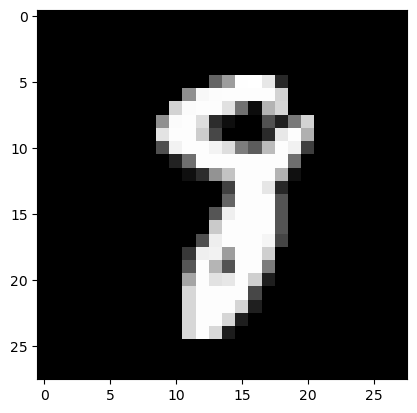

label: 8, pred: 9


In [34]:
img, label = test_set[435]
plt.imshow(img.reshape(28,28), cmap='gray')
plt.show()
print(f'label: {label}, pred: {preds_list[435]}')

# Hook

In [35]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(config['save_path']))
model_best.eval()

record_conv0 = list()
record_conv1 = list()
record_conv2 = list()


def hook_conv0(self, input, output):
    record_conv0.append(output)

def hook_conv1(self, input, output):
    record_conv1.append(output)

def hook_conv2(self, input, output):
    record_conv2.append(output)


model_best.cnn_layers[0].register_forward_hook(hook_conv0)
model_best.cnn_layers[4].register_forward_hook(hook_conv1)
model_best.cnn_layers[8].register_forward_hook(hook_conv2)


test_Img = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)


with torch.no_grad():
    for imgs, labels in test_Img:
        test_pred = model_best(imgs.to(device))


# Feature Map

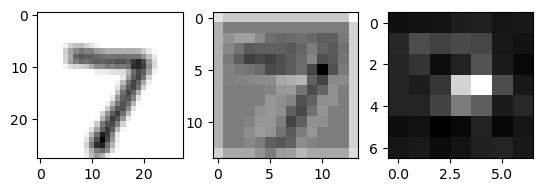

In [36]:
conv0_out = record_conv0[0].squeeze(0)
conv0_out = torch.mean(conv0_out, dim=0)
conv0_out = conv0_out.cpu()

conv1_out = record_conv1[0].squeeze(0)
conv1_out = torch.mean(conv1_out, dim=0)
conv1_out = conv1_out.cpu()

conv2_out = record_conv2[0].squeeze(0)
conv2_out = torch.mean(conv2_out, dim=0)
conv2_out = conv2_out.cpu()

plt.subplot(1,3,1)
plt.imshow(conv0_out, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(conv1_out, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(conv2_out, cmap='gray')
plt.show()